<a href="https://colab.research.google.com/github/1900690/Water-meter-reading/blob/main/water_meter_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#魚眼補正済みの動画から赤色の数字の部分の動画のみを取り出す。

In [ ]:
import cv2
import numpy as np
import os
import requests
from tqdm import tqdm
from google.colab import files
from google.colab.patches import cv2_imshow

# --- 設定エリア ---
# URLを直接指定
REF_URL_1 = "https://github.com/1900690/Water-meter-reading/releases/download/ref/ref_mark1.jpg"
REF_URL_2 = "https://github.com/1900690/Water-meter-reading/releases/download/ref/ref_mark2.jpg"
VIDEO_URL = "https://github.com/1900690/Water-meter-reading/releases/download/movie/seg0_6_ajusted.mp4"

TARGET_REF1_POS = (640, 130)
TARGET_REF2_POS = (550, 510)
TARGET_W, TARGET_H = 1280, 720
ROI_RED_DIGIT = (703, 190, 55, 90) # (x, y, w, h)

# --- ユーティリティ関数 ---

def download_file(url, save_name):
    """URLからファイルをダウンロードする"""
    print(f"ダウンロード中: {url}")
    r = requests.get(url)
    if r.status_code == 200:
        with open(save_name, 'wb') as f:
            f.write(r.content)
        return save_name
    else:
        print(f"ダウンロード失敗: {url}")
        return None

def rotate_image(image, angle):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

def align_image_colab(img, templ1, templ2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    best_score = -1
    best_angle = 0
    for angle in range(-15, 16, 5):
        rotated = rotate_image(gray, angle)
        res = cv2.matchTemplate(rotated, templ1, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_angle = angle

    rotated_img = rotate_image(img, best_angle)
    r_gray = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY)
    _, _, _, p1 = cv2.minMaxLoc(cv2.matchTemplate(r_gray, templ1, cv2.TM_CCOEFF_NORMED))
    _, _, _, p2 = cv2.minMaxLoc(cv2.matchTemplate(r_gray, templ2, cv2.TM_CCOEFF_NORMED))

    src_pts = np.float32([p1, p2])
    dst_pts = np.float32([TARGET_REF1_POS, TARGET_REF2_POS])
    M_fine, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

    if M_fine is None:
        return cv2.resize(rotated_img, (TARGET_W, TARGET_H))
    return cv2.warpAffine(rotated_img, M_fine, (TARGET_W, TARGET_H), borderValue=(255,255,255))

# --- メイン処理 ---

def run_process():
    # 1. 基準画像のダウンロードと読み込み
    ref1_path = download_file(REF_URL_1, "ref1.jpg")
    ref2_path = download_file(REF_URL_2, "ref2.jpg")

    templ1 = cv2.imread(ref1_path, 0)
    templ2 = cv2.imread(ref2_path, 0)

    if templ1 is None or templ2 is None:
        print("エラー: 基準画像の読み込みに失敗しました。")
        return

    # 2. 動画のダウンロード
    video_path = download_file(VIDEO_URL, "input_video.mp4")
    if video_path is None: return

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    x, y, w, h = ROI_RED_DIGIT
    output_filename = "red_digit_output.mp4"
    # コーデックを 'avc1' (H.264) にするとブラウザで再生しやすくなります
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (w, h))

    # 3. プレビュー表示
    ret, first_frame = cap.read()
    if ret:
        aligned_sample = align_image_colab(first_frame, templ1, templ2)
        preview_img = aligned_sample.copy()
        cv2.rectangle(preview_img, (x, y), (x+w, y+h), (0, 0, 255), 3)
        print("\n【確認】以下の赤枠部分（赤色数字）を切り出します：")
        cv2_imshow(cv2.resize(preview_img, (800, 450)))

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # 4. 全フレーム処理
    print(f"\n解析開始: {total_frames} フレームを処理中...")
    for _ in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret: break
        aligned = align_image_colab(frame, templ1, templ2)
        crop = aligned[y:y+h, x:x+w]
        out.write(crop)

    cap.release()
    out.release()
    print(f"\n完了！ ファイル名: {output_filename}")

    # 5. ダウンロード
    #files.download(output_filename)

if __name__ == "__main__":
    run_process()

In [ ]:
import shutil
import cv2
import os

#この動画が画像取り出しされる
LOAD_VIDEO_PATH = '/content/red_digit_output.mp4'  # 修正: 処理する単一の動画ファイルのパスを指定

if os.path.exists("/content/slice"):
  shutil.rmtree("/content/slice")

def save_frame_range(video_path,
                     dir_path, ext='jpg'):

    basename=os.path.splitext(os.path.basename(video_path))[0] # ファイル名から拡張子を除いた部分をbasenameとして使用
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}. It might be missing, corrupted, or an unsupported format.")
        return

    # 動画のプロパティを取得
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT));

    # 真ん中+1のフレームを取り出すプラスの数値を調整することでフレームをずらせる
    # 現在の設定では全フレームを取り出す
    start_frame=0
    stop_frame=total_frames
    step_frame=1

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    # ファイル名の桁数を計算
    digit = len(str(total_frames))

    for n in range(start_frame, stop_frame, step_frame):
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext), frame)
        else:
            # フレームが読み込めない場合はループを終了
            print(f"Warning: Could not read frame {n} from {video_path}. Stopping processing for this video.")
            break

    cap.release() # VideoCaptureオブジェクトを解放
    print(f"Finished processing {video_path}")


#スライスフォルダを作成
SAVE_NAME = 'slice'
if not os.path.exists('/content/' +SAVE_NAME):
    os.mkdir('/content/' +SAVE_NAME)

# 単一の動画ファイルを処理
video_file_name = os.path.basename(LOAD_VIDEO_PATH)
save_dir_for_video = os.path.join('/content/', SAVE_NAME, os.path.splitext(video_file_name)[0])
os.makedirs(save_dir_for_video, exist_ok=True)
save_frame_range(LOAD_VIDEO_PATH, save_dir_for_video)

In [ ]:
import shutil

# Compress the entire '/content/slice' directory into a zip archive
shutil.make_archive(base_name='sliced_images', format='zip', root_dir='/content', base_dir='slice')

#赤色の数字の部分の画像からfastlabel用のインポートアノテーションを作成する

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 11.7 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteZIPファイルをアップロードしてください...


Saving red_digit_output_357.zip to red_digit_output_357.zip
分析開始: 2 枚の画像を処理中...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


分析完了！ CSVファイル 'analysis_results.csv' を作成しました。

--- 分析結果の例 ---
ファイル名: red_digit_output_356.jpg
読み取り値: 5


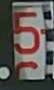

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# 1. 必要なライブラリのインストール
!pip install easyocr

import cv2
import numpy as np
import pandas as pd
import os
import zipfile
import random
import easyocr
from google.colab import files
from IPython.display import display, Image
from datetime import datetime

# 2. OCRモデルの読み込み (数字のみを対象に設定)
reader = easyocr.Reader(['en'])

def recognize_digit(image_path):
    """画像から赤色の数字を抽出して読み取る関数"""
    img = cv2.imread(image_path)
    if img is None:
        return ""

    # BGRからHSVに変換して赤色を抽出
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 赤色の範囲設定 (デジタルメーターの赤に対応)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.addWeighted(mask1, 1.0, mask2, 1.0, 0)

    # OCR実行 (数字のみ、コントラスト調整)
    results = reader.readtext(mask, allowlist='0123456789')

    if len(results) > 0:
        # 最も確信度が高い、あるいは面積が大きそうなものを結合
        return "".join([res[1] for res in results])
    return "NaN"

# 3. ZIPファイルのアップロード
print("ZIPファイルをアップロードしてください...")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# 解凍先ディレクトリの作成
input_dir = 'meter_images'
os.makedirs(input_dir, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(input_dir)

# 4. 全画像の分析
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
data_list = []

print(f"分析開始: {len(image_files)} 枚の画像を処理中...")

for filename in image_files:
    path = os.path.join(input_dir, filename)
    value = recognize_digit(path)

    # ユーザー提供のCSV形式に合わせる
    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
    data_list.append({
        "Name": filename,
        "Status": "registered",
        "Attribute Name": "number",
        "Attribute Value": value,
        "Created At": now,
        "Updated At": now
    })

# 5. CSVの保存
df = pd.DataFrame(data_list)
output_csv = "analysis_results.csv"
df.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(f"分析完了！ CSVファイル '{output_csv}' を作成しました。")

# 6. ランダムに1枚抽出して表示
print("\n--- 分析結果の例 ---")
sample_file = random.choice(image_files)
sample_value = df[df['Name'] == sample_file]['Attribute Value'].values[0]

print(f"ファイル名: {sample_file}")
print(f"読み取り値: {sample_value}")
display(Image(filename=os.path.join(input_dir, sample_file)))

# 7. CSVのダウンロード
#files.download(output_csv)